EXTRA (APÉNDICE)

En este notebook, se entrenan modelos de deep learning (LSTM) utilizando series temporales de las variables que componen OASIS, para predecir la mortalidad hospitalaria. Luego se evalua el rendimiento de los modelos con ACC, AUC-ROC, AUC-PR, confusion matrix...También se realiza Cross Validation y student-t-test para determinar si las diferencias entre los resultados son estadísticamente significativas.

Obs. Ejecute primero '06CreateTimeSeries.ipynb' para obtener 'result_OneBigDataset.csv', 'result_OneBigDataset_y_true.csv', 'result_OneBigDataset_test.csv' y 'result_OneBigDataset_y_true_test.csv'.

In [65]:
import pandas as pd
import numpy as np
np.random.seed(42)
import csv
import os
import sys

In [66]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
import seaborn as sns
matplotlib.style.use('ggplot')

In [67]:
import shutil
import random
random.seed(42)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy import stats


In [68]:
result_OneBigDataset = pd.read_csv('/data/codi/OASIS/timesSeriesv2_cohorte/data/mortality/result_OneBigDataset.csv')
y_true = pd.read_csv('/data/codi/OASIS/timesSeriesv2_cohorte/data/mortality/result_OneBigDataset_y_true.csv')

In [69]:
result_OneBigDataset.head(50)

,Hours,HRATE,MAP,RESP_RATE,TEMP_C,gcs_e,gcs_m,gcs_total_carevue,gcs_v,AGE,PRELOS
0,0,86.0,77.0,19.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
1,1,86.0,77.0,19.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
2,2,86.0,77.0,19.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
3,3,80.0,76.0,29.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
4,4,80.0,76.0,29.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
5,5,68.0,64.0,26.0,36.600000,4.0,6.0,15.0,5.0,77.334247,0.0
6,6,100.0,61.0,25.0,36.111111,4.0,6.0,15.0,5.0,77.334247,0.0
7,7,74.0,69.0,29.0,36.111111,4.0,6.0,15.0,5.0,77.334247,0.0
8,8,77.0,67.0,27.0,35.444444,4.0,6.0,15.0,5.0,77.334247,0.0
9,9,84.0,71.0,28.0,35.444444,4.0,6.0,15.0,5.0,77.334247,0.0


In [70]:
result_OneBigDataset.isnull().sum()

Hours                0
HRATE                0
MAP                  0
RESP_RATE            0
TEMP_C               0
gcs_e                0
gcs_m                0
gcs_total_carevue    0
gcs_v                0
AGE                  0
PRELOS               0
dtype: int64

In [71]:
from sklearn.preprocessing import StandardScaler
result_OneBigDataset = np.array(result_OneBigDataset.drop(['Hours'],axis=1))
scaler = StandardScaler() #normalizar
result_OneBigDataset = scaler.fit_transform(result_OneBigDataset)

In [72]:
#Sin normalizar:
#train_input = np.array(result_OneBigDataset.drop(['Hours'],axis=1)).reshape(y_true.shape[0], 24, 10)
#Normalizado:
train_input = result_OneBigDataset.reshape(y_true.shape[0], 24, 10)

In [73]:
train_input.shape

(17903, 24, 10)

In [74]:
y_true = np.array(y_true)
y_true

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [75]:
y_true.shape

(17903, 1)

In [76]:
result_OneBigDataset_test = pd.read_csv('/data/codi/OASIS/timesSeriesv2_cohorte/data/mortality/result_OneBigDataset_test.csv')
y_true_test = pd.read_csv('/data/codi/OASIS/timesSeriesv2_cohorte/data/mortality/result_OneBigDataset_y_true_test.csv')

In [77]:
result_OneBigDataset_test.head(50)

,Hours,HRATE,MAP,RESP_RATE,TEMP_C,gcs_e,gcs_m,gcs_total_carevue,gcs_v,AGE,PRELOS
0,0,81.0,67.000000,23.0,36.600000,4.0,6.0,15.0,5.0,36.213699,0.0
1,1,76.0,62.666698,21.0,36.333302,4.0,6.0,15.0,5.0,36.213699,0.0
2,2,79.0,65.666702,20.0,36.333302,4.0,6.0,15.0,5.0,36.213699,0.0
3,3,72.0,65.000000,20.0,36.222198,4.0,6.0,15.0,5.0,36.213699,0.0
4,4,74.0,71.000000,21.0,36.222198,4.0,6.0,15.0,5.0,36.213699,0.0
5,5,78.0,67.333298,20.0,36.388901,4.0,6.0,15.0,5.0,36.213699,0.0
6,6,84.0,64.000000,21.0,36.388901,4.0,6.0,15.0,5.0,36.213699,0.0
7,7,95.0,65.666702,20.0,36.388901,4.0,6.0,15.0,5.0,36.213699,0.0
8,8,94.0,62.000000,19.0,37.055599,4.0,6.0,14.0,4.0,36.213699,0.0
9,9,108.0,75.000000,21.0,37.055599,4.0,6.0,14.0,4.0,36.213699,0.0


In [78]:
from sklearn.preprocessing import StandardScaler
result_OneBigDataset_test = np.array(result_OneBigDataset_test.drop(['Hours'],axis=1))
scaler = StandardScaler()
result_OneBigDataset_test = scaler.fit_transform(result_OneBigDataset_test)
test_input = result_OneBigDataset_test.reshape(y_true_test.shape[0], 24, 10)

In [79]:
test_input

array([[[-3.74732223e-03, -7.27005752e-01,  6.46345385e-01, ...,
          7.80504035e-01, -1.66137586e+00, -3.27468222e-01],
        [-3.88666564e-03, -1.01600694e+00,  3.02684882e-01, ...,
          7.80504035e-01, -1.66137586e+00, -3.27468222e-01],
        [-3.80305959e-03, -8.15927471e-01,  1.30854631e-01, ...,
          7.80504035e-01, -1.66137586e+00, -3.27468222e-01],
        ...,
        [-3.80305959e-03, -6.60312682e-01, -5.56466376e-01, ...,
          2.41431713e-01, -1.66137586e+00, -3.27468222e-01],
        [-3.83092828e-03, -8.15927471e-01, -2.12805873e-01, ...,
          2.41431713e-01, -1.66137586e+00, -3.27468222e-01],
        [-3.94240300e-03, -6.38084034e-01, -9.00126879e-01, ...,
          2.41431713e-01, -1.66137586e+00, -3.27468222e-01]],

       [[-4.33256455e-03, -2.60154262e-01, -7.28296627e-01, ...,
          7.80504035e-01,  1.82930468e+00, -3.27468222e-01],
        [-4.36043324e-03, -3.26847332e-01, -1.07195713e+00, ...,
          7.80504035e-01,  1.82930468e

In [80]:
test_input.shape

(3236, 24, 10)

In [81]:
y_true_test = np.array(y_true_test)
y_true_test

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [82]:
y_true_test.shape

(3236, 1)

In [83]:
y_test = y_true_test.ravel()
y_test.shape

(3236,)

In [84]:
#para Cross Validation, usar el dataset completo # Arthur
y = (np.concatenate([y_true, y_true_test], axis=0))
X = (np.concatenate([result_OneBigDataset, result_OneBigDataset_test], axis=0)).reshape(y.shape[0], 24, 10)

In [85]:
X.shape

(21139, 24, 10)

In [86]:
y.shape

(21139, 1)

In [87]:
predictions_output_dir = '/data/codi/OASIS/timesSeriesv2_cohorte/data/mortality/CV/'

### LSTM without class weight

In [24]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM

model = Sequential()
model.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_input, y_true, epochs=8, verbose=1)


2022-05-26 20:31:17.634325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 20:31:17.634369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-26 20:31:21.744964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 20:31:21.744999: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 20:31:21.745029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sony-vaio): /proc/driver/nvidia/version does not exist


Epoch 1/8
560/560 [==============================] - 15s 22ms/step - loss: 0.4005 - accuracy: 0.8417
Epoch 2/8
560/560 [==============================] - 11s 20ms/step - loss: 0.3443 - accuracy: 0.8651
Epoch 3/8
560/560 [==============================] - 10s 18ms/step - loss: 0.3401 - accuracy: 0.8649
Epoch 4/8
560/560 [==============================] - 10s 18ms/step - loss: 0.3394 - accuracy: 0.8649
Epoch 5/8
560/560 [==============================] - 10s 18ms/step - loss: 0.3340 - accuracy: 0.8668
Epoch 6/8
560/560 [==============================] - 10s 19ms/step - loss: 0.3356 - accuracy: 0.8666
Epoch 7/8
560/560 [==============================] - 11s 19ms/step - loss: 0.3342 - accuracy: 0.8659
Epoch 8/8
560/560 [==============================] - 10s 19ms/step - loss: 0.3327 - accuracy: 0.8668


In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
test_output = model.predict(test_input, verbose=1)

102/102 [==============================] - 1s 6ms/step


In [27]:
test_output

array([[0.20526809],
       [0.14530939],
       [0.31590798],
       ...,
       [0.01459944],
       [0.20890284],
       [0.51131535]], dtype=float32)

In [28]:
y_pred = (test_output.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
print('labels(0 survived, 1 dead) predicted: ', y_pred)
print('true labels: ', y_test)

labels(0 survived, 1 dead) predicted:  [0. 0. 0. ... 0. 0. 1.]
true labels:  [1. 0. 0. ... 0. 0. 1.]


In [29]:
from sklearn import metrics

test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
print("Accuracy test:",test_ac)
auroc = metrics.roc_auc_score(y_test, test_output)
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, test_output)
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

Accuracy test: 88.1644
AUC-ROC:  0.7437200342305781
AUC-PR:  0.29993549339638587


In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2804   58]
 [ 325   49]]


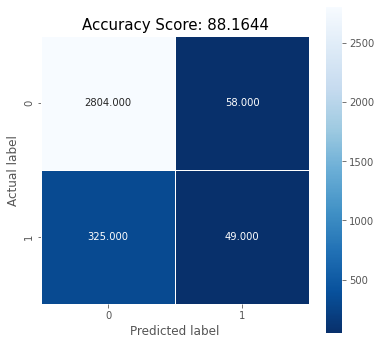

In [31]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((test_ac))
plt.title(all_sample_title, size = 15)
plt.show()

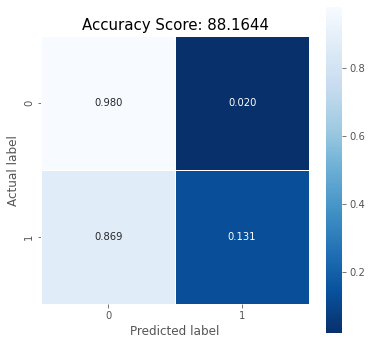

In [32]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_ac)
plt.title(all_sample_title, size = 15)
plt.show()

### LSTM with class weight

In [33]:
classWeight = class_weight.compute_class_weight('balanced',np.unique(np.ravel(y_true)),np.ravel(y_true))
classWeight

array([0.57826227, 3.69438712])

In [34]:
classWeight = {i : classWeight[i] for i in range(2)}  #convert to dictionary in order to fit to keras model
classWeight

{0: 0.5782622739018087, 1: 3.694387123400743}

In [35]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM

model = Sequential()
model.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_input, y_true, epochs=8, verbose=1,class_weight=classWeight)


Epoch 1/8
560/560 [==============================] - 8s 10ms/step - loss: 0.6329 - accuracy: 0.6629
Epoch 2/8
560/560 [==============================] - 6s 10ms/step - loss: 0.5669 - accuracy: 0.7138
Epoch 3/8
560/560 [==============================] - 5s 9ms/step - loss: 0.5735 - accuracy: 0.7064
Epoch 4/8
560/560 [==============================] - 6s 10ms/step - loss: 0.5667 - accuracy: 0.7070
Epoch 5/8
560/560 [==============================] - 5s 10ms/step - loss: 0.5636 - accuracy: 0.7150
Epoch 6/8
560/560 [==============================] - 5s 9ms/step - loss: 0.5517 - accuracy: 0.7100
Epoch 7/8
560/560 [==============================] - 6s 11ms/step - loss: 0.5560 - accuracy: 0.7141
Epoch 8/8
560/560 [==============================] - 5s 10ms/step - loss: 0.5423 - accuracy: 0.7268


In [36]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 20)                1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________
None


Prepare test Dataset, same process

In [39]:
test_output = model.predict(test_input, verbose=1)


102/102 [==============================] - 0s 3ms/step


In [40]:
print(test_output)

[[0.72365683]
 [0.49774703]
 [0.79233277]
 ...
 [0.06404442]
 [0.5926774 ]
 [0.89771557]]


In [41]:
y_pred = (test_output.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)

In [42]:
print('labels(0 survived, 1 dead) predicted: ', y_pred)
print('true labels: ', y_test)

labels(0 survived, 1 dead) predicted:  [1. 0. 1. ... 0. 1. 1.]
true labels:  [1. 0. 0. ... 0. 0. 1.]


In [43]:
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
print("Accuracy test:",test_ac)

Accuracy test: 61.9283


In [39]:
#Manera 2 de calcular Accuracy:
#https://keras.io/api/metrics/accuracy_metrics/
#import tensorflow as tf
#m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
#m.update_state(y_true_test,test_output)
#score = m.result().numpy()
#score

In [44]:
auroc = metrics.roc_auc_score(y_test, test_output)
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, test_output)
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

AUC-ROC:  0.7376390617234124
AUC-PR:  0.2914674011641614


In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1726 1136]
 [  96  278]]


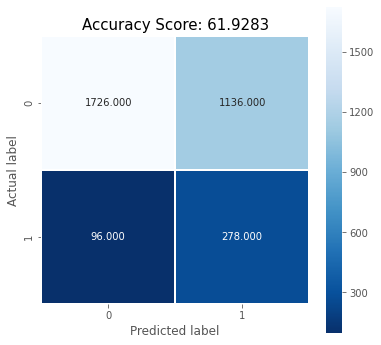

In [46]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((test_ac))
plt.title(all_sample_title, size = 15)
plt.show()

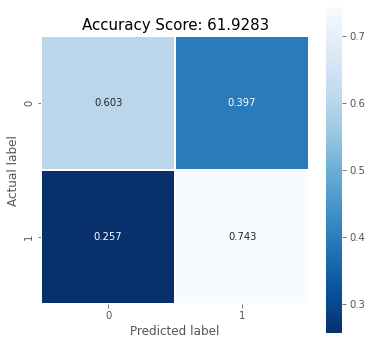

In [47]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_ac)
plt.title(all_sample_title, size = 15)
plt.show()

## Arthur

In [92]:
from tslearn.clustering import TimeSeriesKMeans
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.utils import class_weight

def kfoldclustered(classifier, X, y, weighted=False):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    f = 0;
    aucprs = []
    aucrocs = []
    accuracies = []
    for train, test in cv.split(X, y): #train and test are indexes
        f += 1
        print('KFold ',f,' ---')
        train_input = X[train]
        test_input = X[test]
        y_true = y[train]
        y_test = y[test]
        
        print("---- Clustering Train ---- ")
        # Apply TSCK
        n_clusters = 3
        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_init=1, max_iter=10, random_state=42)
        # Fit to the training data
        kmeans.fit(train_input)
        # Generate out clusters
        train_cluster = kmeans.predict(train_input)
        # Add predicted cluster and y regression label to our training DataFrame
        train_df = list(zip(train_cluster, y_true, train_input))
        ls = sorted(train_df, key=lambda t: t[0])
        # Unzip sorted data
        cluster, y_, data = zip(*ls)
        data = np.array(data)
        y_ = np.array(y_)
        # Getting indexes of clusters division
        c = 0
        ind = []
        for i in range(len(ls)):
            if ls[i][0] > c:
                c = ls[i][0]
                ind.append(i)
        # Removing clusters with less than 10 samples
        d1 = ind[0]
        d2 = ind[1] - ind[0]
        d3 = y_true.shape[0] - ind[1]
        cluster_centers_ = kmeans.cluster_centers_
        if d1 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[1])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[2])
            if dist1 < dist2:
                c = 1
            else:
                c = 2
            train_cluster[:ind[0]] = c
            ind = ind[1:]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 0, 0)
        elif d2 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[0])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[2])
            if dist1 < dist2:
                c = 0
            else:
                c = 2
            train_cluster[ind[0]:ind[1]] = c
            ind = ind[:1]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 1, 0)
        elif d3 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[0])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[1])
            if dist1 < dist2:
                c = 0
            else:
                c = 1
            train_cluster[ind[1]:] = c
            ind = ind[:1]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 2, 0)
            
        print("-------- LSTM fitting for each cluster --------")
        i=0
        if weighted:
            classWeight = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(np.ravel(y_true)),
                                                y=np.ravel(y_true))
            classWeight = {i : classWeight[i] for i in range(2)}
        for index in range(len(ind)+1):
            if index == 0:
                cluster_X = data[:ind[index],:,:]
                cluster_Y = y_[:ind[index]]
            elif index == len(ind):
                cluster_X = data[ind[index-1]:,:,:]
                cluster_Y = y_[ind[index-1]:]
            else:
                cluster_X = data[ind[index-1]:ind[index],:,:]
                cluster_Y = y_[ind[index-1]:ind[index]]
            print(cluster_X.shape)
            
            # LSTM
            model = Sequential()
            model.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
            
            # LSTM
            if weighted == False:
                earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3, restore_best_weights=True)
                saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_tsck{}.h5'.format(f,i))
                history = model.fit(cluster_X, cluster_Y, epochs=10, verbose=1, validation_split=0.15, callbacks=[earlyStop])
                model.save(saved_model_path)
                i += 1
            # LSTM_W
            else:
                print("PASSOU")
                earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3, restore_best_weights=True)
                saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_tsck{}.h5'.format(f,i))
                history = model.fit(cluster_X, cluster_Y, epochs=10, verbose=1, validation_split=0.15, class_weight=classWeight, callbacks=[earlyStop])
                model.save(saved_model_path)
                i += 1
                
        testkfold(f, cluster_centers_, train_cluster, y_, data, ind, y_test, test_input, aucprs, aucrocs, accuracies, weighted)
    return aucprs, aucrocs, accuracies

In [94]:
from keras.models import load_model
def testkfold(f, cluster_centers_, train_cluster, y_, data, ind, y_test, test_input, aucprs, aucrocs, accuracies, weighted):
    # Create initial test data to store assigned clusters
    test_df = list(zip(train_cluster, y_test, test_input))
    # Test sample es asignado al cluster correspondiente mediante Distancia euclidiana y se aplica el modelo correspondiente
    print("Assigning each test sample to the closest cluster centroid...")
    new_cluster = [0 for i in range(y_test.shape[0])]
    for row in range(len(test_df)):
        min_distance = float('inf')
        closest_cluster = None
        for k in range(cluster_centers_.shape[0]):
            # Check if the assigned cluster has more than 100 samples
            # if train_clusters_df[k].shape[0] > 100: # Probar sin limite
            distance = np.linalg.norm(cluster_centers_[k]-test_df[row][2])
            if distance < min_distance:
                min_distance = distance
                closest_cluster = k
        # Assign cluster to test sample
        new_cluster[row] = closest_cluster
    # Sort test data
    test_df = list(zip(new_cluster, y_test, test_input))
    ls_test = sorted(test_df, key=lambda t: t[0])
    # Unzip sorted data
    cluster_t, y_t, data_t = zip(*ls_test)
    data_t = np.array(data_t)
    y_t = np.array(y_t)
    # Getting indexes
    c = 0
    ind_t = []
    for i in range(len(ls_test)):
        if ls_test[i][0] > c:
            c = ls_test[i][0]
            ind_t.append(i)
    print("-------- Train metrics ---------")
    i = 0
    # For each cluster, predict probabilities of class labels
    for index in range(len(ind)+1):
        if index == 0:
            cluster_X = data[:ind[index],:,:]
            cluster_Y = y_[:ind[index]]
        elif index == len(ind):
            cluster_X = data[ind[index-1]:,:,:]
            cluster_Y = y_[ind[index-1]:]
        else:
            cluster_X = data[ind[index-1]:ind[index],:,:]
            cluster_Y = y_[ind[index-1]:ind[index]]
        if weighted:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_tsck{}.h5'.format(f,i))
        else:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_tsck{}.h5'.format(f,i))
        
        model = load_model(saved_model_path)
        classes_prob = model.predict(cluster_X, verbose=1)
        if i == 0:
            train_X_probs = np.array(classes_prob)
            y_train = np.array(cluster_Y)
        else: 
            train_X_probs = np.concatenate((train_X_probs, classes_prob))
            y_train = np.concatenate((y_train, cluster_Y))
        i += 1

    # Test metrics
    print("-------- Test metrics ---------")
    i = 0
    # For each cluster, predict probabilities of class labels
    for index in range(len(ind_t)+1):
        if index == 0:
            cluster_X = data_t[:ind_t[index],:,:]
            cluster_Y = y_t[:ind_t[index]]
        elif index == len(ind):
            cluster_X = data_t[ind_t[index-1]:,:,:]
            cluster_Y = y_t[ind_t[index-1]:]
        else:
            cluster_X = data_t[ind_t[index-1]:ind_t[index],:,:]
            cluster_Y = y_t[ind_t[index-1]:ind_t[index]]
            
        if weighted:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_tsck{}.h5'.format(f,i))
        else:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_tsck{}.h5'.format(f,i))
        model = load_model(saved_model_path)
        classes_prob = model.predict(cluster_X, verbose=1)
        if i == 0:
            test_X_probs = np.array(classes_prob)
            test_y = np.array(cluster_Y)
        else: 
            test_X_probs = np.concatenate((test_X_probs, classes_prob))
            test_y = np.concatenate((test_y, cluster_Y))
        print('----- cluster ',i,' -----')
        print(cluster_X.shape)
        # Test metrics
        y_pred1 = (classes_prob.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
        test_ac1=np.round(metrics.accuracy_score(cluster_Y, y_pred1)*100,4)
        print("Accuracy test cluster ",i,":", test_ac1)
        i += 1
    print("------ Metrics ------")
    # Train metrics
    y_pred_train = (train_X_probs.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
    print('labels(0 short stay, 1 long stay) predicted: ', y_pred_train)
    print('true labels: ', y_train)
    # Test metrics
    y_pred = (test_X_probs.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
    print('labels(0 short stay, 1 long stay) predicted: ', y_pred)
    print('true labels: ', test_y)
    #
    train_ac=np.round(metrics.accuracy_score(y_train, y_pred_train)*100,4)
    print("Accuracy train:", train_ac)
    test_ac=np.round(metrics.accuracy_score(test_y, y_pred)*100,4)
    print("Accuracy test:", test_ac)
    auroc = metrics.roc_auc_score(test_y, test_X_probs)
    print("AUC-ROC: ", auroc)
    (precisions, recalls, thresholds) = metrics.precision_recall_curve(test_y, test_X_probs)
    auprc = metrics.auc(recalls, precisions)
    print("AUC-PR: ", auprc)
    aucprs.append(auprc)
    aucrocs.append(auroc)
    accuracies.append(test_ac)

In [95]:
# Execute LSTM
aucprs, aucrocs, accuracies = kfoldclustered("LSTM", X, y, weighted = False)

KFold  1  ---
---- Clustering Train ---- 
-------- LSTM fitting for each cluster --------
(1461, 24, 10)
Epoch 1/10
39/39 [==============================] - 5s 34ms/step - loss: 0.6429 - accuracy: 0.6575 - val_loss: 0.5644 - val_accuracy: 0.7909
Epoch 2/10
39/39 [==============================] - 1s 21ms/step - loss: 0.5573 - accuracy: 0.7768 - val_loss: 0.5200 - val_accuracy: 0.7909
Epoch 3/10
39/39 [==============================] - 1s 19ms/step - loss: 0.5332 - accuracy: 0.7776 - val_loss: 0.5035 - val_accuracy: 0.7909
Epoch 4/10
39/39 [==============================] - 1s 18ms/step - loss: 0.5198 - accuracy: 0.7768 - val_loss: 0.4930 - val_accuracy: 0.7909
Epoch 5/10
39/39 [==============================] - 1s 19ms/step - loss: 0.5092 - accuracy: 0.7768 - val_loss: 0.4841 - val_accuracy: 0.7909
Epoch 6/10
39/39 [==============================] - 1s 18ms/step - loss: 0.4934 - accuracy: 0.7776 - val_loss: 0.4770 - val_accuracy: 0.7909
Epoch 7/10
39/39 [==============================]

274/274 [==============================] - 5s 18ms/step - loss: 0.2775 - accuracy: 0.9119 - val_loss: 0.2245 - val_accuracy: 0.9320
Epoch 3/10
274/274 [==============================] - 5s 18ms/step - loss: 0.2709 - accuracy: 0.9123 - val_loss: 0.2255 - val_accuracy: 0.9320
Epoch 4/10
274/274 [==============================] - 5s 20ms/step - loss: 0.2681 - accuracy: 0.9131 - val_loss: 0.2274 - val_accuracy: 0.9327
Epoch 5/10
274/274 [==============================] - 5s 20ms/step - loss: 0.2666 - accuracy: 0.9123 - val_loss: 0.2316 - val_accuracy: 0.9340
Epoch 5: early stopping
Assigning each test sample to the closest cluster centroid...
-------- Train metrics ---------
322/322 [==============================] - 2s 6ms/step
-------- Test metrics ---------
33/33 [==============================] - 1s 5ms/step
----- cluster  0  -----
(1044, 24, 10)
Accuracy test cluster  0 : 82.1839
20/20 [==============================] - 0s 5ms/step
----- cluster  1  -----
(630, 24, 10)
Accuracy test c

48/48 [==============================] - 1s 20ms/step - loss: 0.5712 - accuracy: 0.6889 - val_loss: 0.4882 - val_accuracy: 0.7889
Epoch 10/10
48/48 [==============================] - 2s 35ms/step - loss: 0.5629 - accuracy: 0.6974 - val_loss: 0.4796 - val_accuracy: 0.7852
(11638, 24, 10)
Epoch 1/10
310/310 [==============================] - 18s 43ms/step - loss: 0.3548 - accuracy: 0.8895 - val_loss: 0.2735 - val_accuracy: 0.9124
Epoch 2/10
310/310 [==============================] - 7s 22ms/step - loss: 0.3035 - accuracy: 0.8973 - val_loss: 0.2696 - val_accuracy: 0.9118
Epoch 3/10
310/310 [==============================] - 7s 23ms/step - loss: 0.2988 - accuracy: 0.8969 - val_loss: 0.2684 - val_accuracy: 0.9124
Epoch 4/10
310/310 [==============================] - 7s 23ms/step - loss: 0.2946 - accuracy: 0.8973 - val_loss: 0.2658 - val_accuracy: 0.9112
Epoch 5/10
310/310 [==============================] - 5s 17ms/step - loss: 0.2938 - accuracy: 0.8973 - val_loss: 0.2649 - val_accuracy: 0.9

68/68 [==============================] - 1s 4ms/step
-------- Test metrics ---------
35/35 [==============================] - 0s 4ms/step
----- cluster  0  -----
(1100, 24, 10)
Accuracy test cluster  0 : 80.8182
82/82 [==============================] - 1s 4ms/step
----- cluster  1  -----
(2603, 24, 10)
Accuracy test cluster  1 : 91.2025
17/17 [==============================] - 0s 5ms/step
----- cluster  2  -----
(524, 24, 10)
Accuracy test cluster  2 : 76.5267
------ Metrics ------
labels(0 short stay, 1 long stay) predicted:  [0. 0. 0. ... 0. 0. 0.]
true labels:  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
labels(0 short stay, 1 long stay) predicted:  [0. 0. 0. ... 0. 0. 0.]
true labels:  [[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
Accuracy train: 87.0684
Accuracy test: 86.6809
AUC-ROC:  0.7775863473128204
AUC-PR:  0.3498176749932243


In [96]:
print ('aucpr scores:', aucprs)
print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs), np.std(aucprs)))

print ('aucroc scores:', aucrocs)
print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs), np.std(aucrocs)))

print ('accuracy scores:', accuracies)
print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies), np.std(accuracies)))

aucpr scores: [0.36626203681705416, 0.38288389666568506, 0.3876778820247252, 0.3545150960616736, 0.3498176749932243]
0.3682 mean aucpr with a standard deviation of 0.0150
aucroc scores: [0.7704547602843314, 0.7934405329274967, 0.788776753715523, 0.7809994117860496, 0.7775863473128204]
0.7823 mean aucroc with a standard deviation of 0.0081
accuracy scores: [86.3529, 86.4948, 87.0151, 87.772, 86.6809]
86.8631 mean accuracy with a standard deviation of 0.5056


In [31]:
# Execute LSTM_w
aucprs_w, aucrocs_w, accuracies_w = kfoldclustered("LSTM", X, y, True)

KFold  1  ---
---- Clustering Train ---- 
-------- LSTM fitting for each cluster --------
(1461, 24, 10)
PASSOU
Epoch 1/10
39/39 [==============================] - 4s 30ms/step - loss: 0.8466 - accuracy: 0.2393 - val_loss: 0.9246 - val_accuracy: 0.2091
Epoch 2/10
39/39 [==============================] - 1s 19ms/step - loss: 0.8144 - accuracy: 0.2409 - val_loss: 0.9044 - val_accuracy: 0.2091
Epoch 3/10
39/39 [==============================] - 1s 19ms/step - loss: 0.7964 - accuracy: 0.2716 - val_loss: 0.8908 - val_accuracy: 0.2091
Epoch 4/10
39/39 [==============================] - 1s 19ms/step - loss: 0.7837 - accuracy: 0.2836 - val_loss: 0.8781 - val_accuracy: 0.2227
Epoch 5/10
39/39 [==============================] - 1s 19ms/step - loss: 0.7718 - accuracy: 0.3207 - val_loss: 0.8456 - val_accuracy: 0.2864
Epoch 6/10
39/39 [==============================] - 1s 19ms/step - loss: 0.7608 - accuracy: 0.3844 - val_loss: 0.8462 - val_accuracy: 0.3182
Epoch 7/10
39/39 [========================

310/310 [==============================] - 5s 15ms/step - loss: 0.5229 - accuracy: 0.7543 - val_loss: 0.5612 - val_accuracy: 0.6695
Epoch 7: early stopping
(3473, 24, 10)
PASSOU
Epoch 1/10
93/93 [==============================] - 4s 20ms/step - loss: 0.7393 - accuracy: 0.4624 - val_loss: 0.7603 - val_accuracy: 0.2956
Epoch 2/10
93/93 [==============================] - 1s 15ms/step - loss: 0.7102 - accuracy: 0.4387 - val_loss: 0.7628 - val_accuracy: 0.3762
Epoch 3/10
93/93 [==============================] - 1s 16ms/step - loss: 0.6882 - accuracy: 0.5051 - val_loss: 0.7219 - val_accuracy: 0.4971
Epoch 4/10
93/93 [==============================] - 1s 15ms/step - loss: 0.6615 - accuracy: 0.5752 - val_loss: 0.7253 - val_accuracy: 0.5125
Epoch 5/10
93/93 [==============================] - 1s 16ms/step - loss: 0.6432 - accuracy: 0.5969 - val_loss: 0.6774 - val_accuracy: 0.5931
Epoch 6/10
93/93 [==============================] - 1s 15ms/step - loss: 0.6403 - accuracy: 0.6084 - val_loss: 0.6715

In [32]:
print ('aucpr scores:', aucprs_w)
print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs_w), np.std(aucprs_w)))

print ('aucroc scores:', aucrocs_w)
print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs_w), np.std(aucrocs_w)))

print ('accuracy scores:', accuracies_w)
print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies_w), np.std(accuracies_w)))

aucpr scores: [0.3674493533739938, 0.376578202239015, 0.37975814067858527, 0.3092122944054935, 0.34682130883568246]
0.3560 mean aucpr with a standard deviation of 0.0260
aucroc scores: [0.769314078569268, 0.7883527955617345, 0.7972137093928165, 0.7728569158067039, 0.7749220489113995]
0.7805 mean aucroc with a standard deviation of 0.0105
accuracy scores: [69.4418, 74.9527, 71.1684, 71.334, 70.7121]
71.5218 mean accuracy with a standard deviation of 1.8392


### K-Means

In [88]:
from sklearn.cluster import KMeans
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.utils import class_weight

def kfoldclusteredkmeans(classifier, X, y, weighted=False):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    f = 0;
    aucprs = []
    aucrocs = []
    accuracies = []
    for train, test in cv.split(X, y): #train and test are indexes
        f += 1
        print('KFold ',f,' ---')
        train_input = X[train]
        test_input = X[test]
        y_true = y[train]
        y_test = y[test]
        
        print("---- Clustering Train ---- ")
        # Apply KMeans
        n_clusters = 3
        kmeans = KMeans(
            init="random",
            n_clusters=n_clusters,
            n_init=10,
            max_iter=300,
            random_state=42
        )
        # Fit to the training data
        kmeans.fit(train_input.reshape(y_true.shape[0], 24*10))
         # Generate out clusters
        train_cluster = kmeans.predict(train_input.reshape(y_true.shape[0], 24*10))
        # Add predicted cluster and y regression label to our training DataFrame
        train_df = list(zip(train_cluster, y_true, train_input))
        ls = sorted(train_df, key=lambda t: t[0])
        # Unzip sorted data
        cluster, y_, data = zip(*ls)
        data = np.array(data)
        y_ = np.array(y_)
        # Getting indexes of clusters division
        c = 0
        ind = []
        for i in range(len(ls)):
            if ls[i][0] > c:
                c = ls[i][0]
                ind.append(i)
        # Removing clusters with less than 10 samples
        d1 = ind[0]
        d2 = ind[1] - ind[0]
        d3 = y_true.shape[0] - ind[1]
        cluster_centers_ = kmeans.cluster_centers_
        if d1 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[1])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[2])
            if dist1 < dist2:
                c = 1
            else:
                c = 2
            train_cluster[:ind[0]] = c
            ind = ind[1:]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 0, 0)
        elif d2 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[0])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[2])
            if dist1 < dist2:
                c = 0
            else:
                c = 2
            train_cluster[ind[0]:ind[1]] = c
            ind = ind[:1]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 1, 0)
        elif d3 < 10:
            dist1 = np.linalg.norm(kmeans.cluster_centers_[0])
            dist2 = np.linalg.norm(kmeans.cluster_centers_[1])
            if dist1 < dist2:
                c = 0
            else:
                c = 1
            train_cluster[ind[1]:] = c
            ind = ind[:1]
            cluster_centers_ = np.delete(kmeans.cluster_centers_, 2, 0)
            
        print("-------- LSTM fitting for each cluster --------")
        i=0
        if weighted:
            classWeight = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(np.ravel(y_true)),
                                                y=np.ravel(y_true))
            classWeight = {i : classWeight[i] for i in range(2)}
        for index in range(len(ind)+1):
            if index == 0:
                cluster_X = data[:ind[index],:,:]
                cluster_Y = y_[:ind[index]]
            elif index == len(ind):
                cluster_X = data[ind[index-1]:,:,:]
                cluster_Y = y_[ind[index-1]:]
            else:
                cluster_X = data[ind[index-1]:ind[index],:,:]
                cluster_Y = y_[ind[index-1]:ind[index]]
            print(cluster_X.shape)
            
            # LSTM
            model = Sequential()
            model.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
        
            
            # LSTM
            if weighted == False:
                earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3, restore_best_weights=True)
                saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_kmeans{}.h5'.format(f,i))
                history = model.fit(cluster_X, cluster_Y, epochs=10, verbose=1, validation_split=0.15, callbacks=[earlyStop])
                model.save(saved_model_path)
                i += 1
            # LSTM_W
            else:
                print("PASSOU")
                earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3, restore_best_weights=True)
                saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_kmeans{}.h5'.format(f,i))
                history = model.fit(cluster_X, cluster_Y, epochs=10, verbose=1, validation_split=0.15, class_weight=classWeight, callbacks=[earlyStop])
                model.save(saved_model_path)
                i += 1
                
        testkfoldkmeans(f, cluster_centers_, train_cluster, y_, data, ind, y_test, test_input, aucprs, aucrocs, accuracies, weighted)
    return aucprs, aucrocs, accuracies

In [89]:
from keras.models import load_model
def testkfoldkmeans(f, cluster_centers_, train_cluster, y_, data, ind, y_test, test_input, aucprs, aucrocs, accuracies, weighted):
    # Create initial test data to store assigned clusters
    test_df = list(zip(train_cluster, y_test, test_input))
    # Test sample es asignado al cluster correspondiente mediante Distancia euclidiana y se aplica el modelo correspondiente
    print("Assigning each test sample to the closest cluster centroid...")
    new_cluster = [0 for i in range(y_test.shape[0])]
    for row in range(len(test_df)):
        min_distance = float('inf')
        closest_cluster = None
        for k in range(cluster_centers_.shape[0]):
            # Check if the assigned cluster has more than 100 samples
            # if train_clusters_df[k].shape[0] > 100: # Probar sin limite
            distance = np.linalg.norm(cluster_centers_[k]-test_df[row][2].reshape(240))
            if distance < min_distance:
                min_distance = distance
                closest_cluster = k
        # Assign cluster to test sample
        new_cluster[row] = closest_cluster
    # Sort test data
    test_df = list(zip(new_cluster, y_test, test_input))
    ls_test = sorted(test_df, key=lambda t: t[0])
    # Unzip sorted data
    cluster_t, y_t, data_t = zip(*ls_test)
    data_t = np.array(data_t)
    y_t = np.array(y_t)
    # Getting indexes
    c = 0
    ind_t = []
    for i in range(len(ls_test)):
        if ls_test[i][0] > c:
            c = ls_test[i][0]
            ind_t.append(i)
    print("-------- Train metrics ---------")
    i = 0
    # For each cluster, predict probabilities of class labels
    for index in range(len(ind)+1):
        if index == 0:
            cluster_X = data[:ind[index],:,:]
            cluster_Y = y_[:ind[index]]
        elif index == len(ind):
            cluster_X = data[ind[index-1]:,:,:]
            cluster_Y = y_[ind[index-1]:]
        else:
            cluster_X = data[ind[index-1]:ind[index],:,:]
            cluster_Y = y_[ind[index-1]:ind[index]]
        if weighted:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_kmeans{}.h5'.format(f,i))
        else:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_kmeans{}.h5'.format(f,i))
        
        model = load_model(saved_model_path)
        classes_prob = model.predict(cluster_X, verbose=1)
        if i == 0:
            train_X_probs = np.array(classes_prob)
            y_train = np.array(cluster_Y)
        else: 
            train_X_probs = np.concatenate((train_X_probs, classes_prob))
            y_train = np.concatenate((y_train, cluster_Y))
        i += 1

    # Test metrics
    print("-------- Test metrics ---------")
    i = 0
    # For each cluster, predict probabilities of class labels
    for index in range(len(ind_t)+1):
        if index == 0:
            cluster_X = data_t[:ind_t[index],:,:]
            cluster_Y = y_t[:ind_t[index]]
        elif index == len(ind):
            cluster_X = data_t[ind_t[index-1]:,:,:]
            cluster_Y = y_t[ind_t[index-1]:]
        else:
            cluster_X = data_t[ind_t[index-1]:ind_t[index],:,:]
            cluster_Y = y_t[ind_t[index-1]:ind_t[index]]
            
        if weighted:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_w_kmeans{}.h5'.format(f,i))
        else:
            saved_model_path = os.path.join(predictions_output_dir, 'cv{}_lstm_kmeans{}.h5'.format(f,i))
        model = load_model(saved_model_path)
        classes_prob = model.predict(cluster_X, verbose=1)
        if i == 0:
            test_X_probs = np.array(classes_prob)
            test_y = np.array(cluster_Y)
        else: 
            test_X_probs = np.concatenate((test_X_probs, classes_prob))
            test_y = np.concatenate((test_y, cluster_Y))
        print('----- cluster ',i,' -----')
        print(cluster_X.shape)
        # Test metrics
        y_pred1 = (classes_prob.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
        test_ac1=np.round(metrics.accuracy_score(cluster_Y, y_pred1)*100,4)
        print("Accuracy test cluster ",i,":", test_ac1)
        
        i += 1
    print("------ Metrics ------")
    # Train metrics
    y_pred_train = (train_X_probs.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
    print('labels(0 short stay, 1 long stay) predicted: ', y_pred_train)
    print('true labels: ', y_train)
    # Test metrics
    y_pred = (test_X_probs.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
    print('labels(0 short stay, 1 long stay) predicted: ', y_pred)
    print('true labels: ', test_y)
    #
    train_ac=np.round(metrics.accuracy_score(y_train, y_pred_train)*100,4)
    print("Accuracy train:", train_ac)
    test_ac=np.round(metrics.accuracy_score(test_y, y_pred)*100,4)
    print("Accuracy test:", test_ac)
    auroc = metrics.roc_auc_score(test_y, test_X_probs)
    print("AUC-ROC: ", auroc)
    (precisions, recalls, thresholds) = metrics.precision_recall_curve(test_y, test_X_probs)
    auprc = metrics.auc(recalls, precisions)
    print("AUC-PR: ", auprc)
    aucprs.append(auprc)
    aucrocs.append(auroc)
    accuracies.append(test_ac)

In [90]:
# Execute LSTM
aucprs_w, aucrocs_w, accuracies_w = kfoldclusteredkmeans("LSTM", X, y, False)

KFold  1  ---
---- Clustering Train ---- 
-------- LSTM fitting for each cluster --------
(481, 24, 10)
Epoch 1/10
13/13 [==============================] - 4s 94ms/step - loss: 0.6662 - accuracy: 0.5711 - val_loss: 0.6192 - val_accuracy: 0.7260
Epoch 2/10
13/13 [==============================] - 1s 53ms/step - loss: 0.6286 - accuracy: 0.7010 - val_loss: 0.5881 - val_accuracy: 0.7260
Epoch 3/10
13/13 [==============================] - 1s 41ms/step - loss: 0.5969 - accuracy: 0.7426 - val_loss: 0.5754 - val_accuracy: 0.7260
Epoch 4/10
13/13 [==============================] - 0s 27ms/step - loss: 0.5948 - accuracy: 0.7451 - val_loss: 0.5700 - val_accuracy: 0.7260
Epoch 5/10
13/13 [==============================] - 0s 30ms/step - loss: 0.5813 - accuracy: 0.7475 - val_loss: 0.5676 - val_accuracy: 0.7260
Epoch 6/10
13/13 [==============================] - 0s 29ms/step - loss: 0.5779 - accuracy: 0.7451 - val_loss: 0.5654 - val_accuracy: 0.7260
Epoch 7/10
13/13 [==============================] 

Epoch 5/10
293/293 [==============================] - 5s 17ms/step - loss: 0.2749 - accuracy: 0.9108 - val_loss: 0.2406 - val_accuracy: 0.9303
Epoch 5: early stopping
(409, 24, 10)
Epoch 1/10
11/11 [==============================] - 5s 75ms/step - loss: 1.1043 - accuracy: 0.2767 - val_loss: 1.0850 - val_accuracy: 0.2258
Epoch 2/10
11/11 [==============================] - 0s 19ms/step - loss: 0.9875 - accuracy: 0.2767 - val_loss: 0.9763 - val_accuracy: 0.2258
Epoch 3/10
11/11 [==============================] - 0s 48ms/step - loss: 0.9002 - accuracy: 0.2795 - val_loss: 0.8859 - val_accuracy: 0.2258
Epoch 4/10
11/11 [==============================] - 1s 53ms/step - loss: 0.8248 - accuracy: 0.2997 - val_loss: 0.8103 - val_accuracy: 0.2258
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 0.7561 - accuracy: 0.3689 - val_loss: 0.7469 - val_accuracy: 0.2581
Epoch 6/10
11/11 [==============================] - 0s 20ms/step - loss: 0.6942 - accuracy: 0.5072 - val_loss: 0.6

In [56]:
# Bigest cluster
acc_test = [0.915033, 0.909617, 0.917919, 0.914317, 0.913482]
acc_train = [0.9131, 0.9127, 0.9119, 0.9108, 0.9115]

In [91]:
print ('aucpr scores:', aucprs_w)
print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs_w), np.std(aucprs_w)))

print ('aucroc scores:', aucrocs_w)
print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs_w), np.std(aucrocs_w)))

print ('accuracy scores:', accuracies_w)
print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies_w), np.std(accuracies_w)))

aucpr scores: [0.3671300924689447, 0.37740440173099943, 0.37830638105328607, 0.34712608191939226, 0.351275747028477]
0.3642 mean aucpr with a standard deviation of 0.0130
aucroc scores: [0.7735674720205687, 0.7918580945133872, 0.7939284619602799, 0.7757075304161806, 0.7726499298052386]
0.7815 mean aucroc with a standard deviation of 0.0093
accuracy scores: [86.3529, 86.6367, 87.3226, 87.7247, 87.0121]
87.0098 mean accuracy with a standard deviation of 0.4857


In [58]:
# Execute LSTM
aucprs_w, aucrocs_w, accuracies_w = kfoldclusteredkmeans("LSTM", X, y, True)

KFold  1  ---
---- Clustering Train ---- 
-------- LSTM fitting for each cluster --------
(481, 24, 10)
PASSOU
Epoch 1/10
13/13 [==============================] - 3s 58ms/step - loss: 0.9119 - accuracy: 0.3162 - val_loss: 0.8105 - val_accuracy: 0.2740
Epoch 2/10
13/13 [==============================] - 0s 25ms/step - loss: 0.8806 - accuracy: 0.2794 - val_loss: 0.8469 - val_accuracy: 0.2740
Epoch 3/10
13/13 [==============================] - 0s 25ms/step - loss: 0.8622 - accuracy: 0.2574 - val_loss: 0.8845 - val_accuracy: 0.2740
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 0.8676 - accuracy: 0.2475 - val_loss: 0.9048 - val_accuracy: 0.2740
Epoch 4: early stopping
(5420, 24, 10)
PASSOU
Epoch 1/10
144/144 [==============================] - 6s 22ms/step - loss: 0.8182 - accuracy: 0.2496 - val_loss: 0.9437 - val_accuracy: 0.1845
Epoch 2/10
144/144 [==============================] - 3s 19ms/step - loss: 0.7697 - accuracy: 0.3321 - val_loss: 0.8826 - val_accuracy: 

-------- LSTM fitting for each cluster --------
(5337, 24, 10)
PASSOU
Epoch 1/10
142/142 [==============================] - 6s 22ms/step - loss: 0.8071 - accuracy: 0.2478 - val_loss: 0.8949 - val_accuracy: 0.1985
Epoch 2/10
142/142 [==============================] - 3s 19ms/step - loss: 0.7606 - accuracy: 0.3419 - val_loss: 0.8409 - val_accuracy: 0.3508
Epoch 3/10
142/142 [==============================] - 3s 19ms/step - loss: 0.7351 - accuracy: 0.4464 - val_loss: 0.8453 - val_accuracy: 0.4257
Epoch 4/10
142/142 [==============================] - 3s 19ms/step - loss: 0.7210 - accuracy: 0.4971 - val_loss: 0.8056 - val_accuracy: 0.5006
Epoch 5/10
142/142 [==============================] - 3s 19ms/step - loss: 0.7119 - accuracy: 0.5214 - val_loss: 0.7672 - val_accuracy: 0.5381
Epoch 6/10
142/142 [==============================] - 3s 19ms/step - loss: 0.7046 - accuracy: 0.5412 - val_loss: 0.7579 - val_accuracy: 0.5518
Epoch 7/10
142/142 [==============================] - 3s 19ms/step - los

IOStream.flush timed out


295/295 [==============================] - 22s 31ms/step - loss: 0.5553 - accuracy: 0.7852 - val_loss: 0.4429 - val_accuracy: 0.9147
Epoch 2/10
295/295 [==============================] - 6s 19ms/step - loss: 0.5212 - accuracy: 0.8250 - val_loss: 0.4432 - val_accuracy: 0.8589
Epoch 3/10
295/295 [==============================] - 6s 19ms/step - loss: 0.5107 - accuracy: 0.8008 - val_loss: 0.4755 - val_accuracy: 0.7940
Epoch 4/10
295/295 [==============================] - 6s 19ms/step - loss: 0.4971 - accuracy: 0.7980 - val_loss: 0.5030 - val_accuracy: 0.7483
Epoch 4: early stopping
(478, 24, 10)
PASSOU
Epoch 1/10
13/13 [==============================] - 3s 56ms/step - loss: 1.6725 - accuracy: 0.7389 - val_loss: 0.5267 - val_accuracy: 0.7917
Epoch 2/10
13/13 [==============================] - 0s 23ms/step - loss: 1.4789 - accuracy: 0.7389 - val_loss: 0.5405 - val_accuracy: 0.7917
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 1.3025 - accuracy: 0.7389 - val_loss: 

Epoch 3/10
293/293 [==============================] - 6s 19ms/step - loss: 0.5086 - accuracy: 0.7952 - val_loss: 0.5036 - val_accuracy: 0.7498
Epoch 4/10
293/293 [==============================] - 6s 19ms/step - loss: 0.4996 - accuracy: 0.7949 - val_loss: 0.5203 - val_accuracy: 0.7287
Epoch 5/10
293/293 [==============================] - 5s 19ms/step - loss: 0.4935 - accuracy: 0.7888 - val_loss: 0.5029 - val_accuracy: 0.7299
Epoch 5: early stopping
(5446, 24, 10)
PASSOU
Epoch 1/10
145/145 [==============================] - 6s 22ms/step - loss: 0.8126 - accuracy: 0.3407 - val_loss: 0.8527 - val_accuracy: 0.2656
Epoch 2/10
145/145 [==============================] - 3s 19ms/step - loss: 0.7405 - accuracy: 0.4290 - val_loss: 0.7900 - val_accuracy: 0.4761
Epoch 3/10
145/145 [==============================] - 3s 19ms/step - loss: 0.7045 - accuracy: 0.5250 - val_loss: 0.8020 - val_accuracy: 0.5202
Epoch 4/10
145/145 [==============================] - 3s 19ms/step - loss: 0.6980 - accuracy: 0.

## Li

In [59]:
#manera 2
#https://amirhessam88.github.io/roc-vs-pr/

def customCrossValidationMetrics(classifier, X, y, weighted = False  ):
    scaler = StandardScaler()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    #ejemplo classifier=RandomForestClassifier(n_estimators=10, random_state = 42)
    aucprs = []
    aucrocs = []
    accuracies = []
    
    i=1
    for train, test in cv.split(X, y): #train and test are indexes
        print('KFold ',i)
        #reshape because scaler need <= 2d
        X_train_tranformed = scaler.fit_transform(X[train].reshape(train.shape[0]*24, 10))
        X_test_tranformed = scaler.transform(X[test].reshape(test.shape[0]*24, 10))
        
        #re-reshape
        
        X_train_tranformed = X_train_tranformed.reshape(train.shape[0], 24, 10)
        X_test_tranformed = X_test_tranformed.reshape(test.shape[0], 24, 10)
        
        if(weighted):
            classWeight = class_weight.compute_class_weight('balanced',np.unique(np.ravel(y[train])),np.ravel(y[train]))
            classWeight = {i : classWeight[i] for i in range(2)}  #convert to dictionary in order to fit to keras model
            print("training: ")
            history = classifier.fit(X_train_tranformed, np.ravel(y[train]), epochs=8, verbose=1,class_weight=classWeight)

        else:
            print("training: ")
            history = classifier.fit(X_train_tranformed, np.ravel(y[train]),epochs=8, verbose=1)

        print("testing: ")
        probas_ = np.ravel(classifier.predict(X_test_tranformed, verbose=1))
        # Compute PR curve and area the curve
        precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_)
        pr_auc =  np.round(metrics.auc(recall, precision), 6)
        aucprs.append(pr_auc)
        auroc =  np.round(metrics.roc_auc_score(y[test],probas_),6)
        aucrocs.append(auroc)

        y_pred_binary = classifier.predict(X_test_tranformed)
        y_pred_binary = (y_pred_binary.ravel()>0.5) + 0.0 # predict and get class (0 if pred < 0.5 else 1)
        acc = np.round(metrics.accuracy_score(y[test],y_pred_binary)*100,4)
        accuracies.append(acc)
        
        i = i+1

    print ('aucpr scores:', aucprs)
    print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs), np.std(aucprs)))

    print ('aucroc scores:', aucrocs)
    print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs), np.std(aucrocs)))

    print ('accuracy scores:', accuracies)
    print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies), np.std(accuracies)))
    
    return aucprs, aucrocs, accuracies


In [60]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM

classifier = Sequential()
classifier.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
classifier.add(Dropout(0.2))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


In [61]:
aucprs_LSTM, aucrocs_LSTM, accuracies_LSTM = customCrossValidationMetrics(classifier, X, y, weighted = False)

KFold  1
training: 
Epoch 1/8
529/529 [==============================] - 15s 20ms/step - loss: 0.4437 - accuracy: 0.7985
Epoch 2/8
529/529 [==============================] - 11s 21ms/step - loss: 0.3403 - accuracy: 0.8685
Epoch 3/8
529/529 [==============================] - 10s 19ms/step - loss: 0.3337 - accuracy: 0.8709
Epoch 4/8
529/529 [==============================] - 10s 19ms/step - loss: 0.3327 - accuracy: 0.8698
Epoch 5/8
529/529 [==============================] - 14s 26ms/step - loss: 0.3304 - accuracy: 0.8710
Epoch 6/8
529/529 [==============================] - 12s 22ms/step - loss: 0.3300 - accuracy: 0.8699
Epoch 7/8
529/529 [==============================] - 10s 19ms/step - loss: 0.3279 - accuracy: 0.8698
Epoch 8/8
529/529 [==============================] - 12s 22ms/step - loss: 0.3269 - accuracy: 0.8707
testing: 
133/133 [==============================] - 1s 6ms/step
KFold  2
training: 
Epoch 1/8
529/529 [==============================] - 11s 20ms/step - loss: 0.3301 - acc

In [52]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Model
from keras.layers import Flatten, LSTM

classifier_weighted = Sequential()
classifier_weighted.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(24, 10)))
classifier_weighted.add(Dropout(0.2))
classifier_weighted.add(Dense(1, activation='sigmoid'))
classifier_weighted.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


In [53]:
aucprs_LSTM_weighted, aucrocs_LSTM_weighted, accuracies_LSTM_weighted = customCrossValidationMetrics(classifier_weighted, X, y, weighted = True)

KFold  1
training: 
Epoch 1/8
529/529 [==============================] - 6s 8ms/step - loss: 0.6720 - accuracy: 0.4515
Epoch 2/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5829 - accuracy: 0.6987
Epoch 3/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5799 - accuracy: 0.7092
Epoch 4/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5783 - accuracy: 0.6979
Epoch 5/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5601 - accuracy: 0.7230
Epoch 6/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5589 - accuracy: 0.7147
Epoch 7/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5629 - accuracy: 0.7116
Epoch 8/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5571 - accuracy: 0.7231
testing: 
133/133 [==============================] - 1s 2ms/step
KFold  2
training: 
Epoch 1/8
529/529 [==============================] - 4s 8ms/step - loss: 0.5601 - accuracy: 0.7094
Epoc

Compare Statistical Significance Tests for Comparing Machine Learning Algorithms

https://stackoverflow.com/questions/54498235/compare-whether-the-difference-between-performance-accuracy-of-2-ml-models-is-st

In [54]:
print('LSTM vs LSTM_weighted AUCROC: ', stats.ttest_rel(aucrocs_LSTM,aucrocs_LSTM_weighted))


LSTM vs LSTM_weighted AUCROC:  Ttest_relResult(statistic=-1.3258967258799943, pvalue=0.2555220127917172)


In [55]:
print('LSTM vs LSTM_weighted AUCPR: ', stats.ttest_rel(aucprs_LSTM,aucprs_LSTM_weighted))


LSTM vs LSTM_weighted AUCPR:  Ttest_relResult(statistic=1.715553266087846, pvalue=0.1613879046592789)


las diferencias de aucroc y aucpr entre LSTM y LSTM_weighted no son estadísticamente significativas. (p_value > 0.05, no podemos rechazar la hipotesi nula de que los modelos tienen comportamiento similar)  